In [1]:
# importing essential libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from keras import layers
from tensorflow import data as tf_data

In [2]:
# getting data from the dataset of 'oxford_iiit_pet:3.2.0'
# This dataset contains 37 pet breeds
# dividing them to train, validation and test datasets
train_dataset, validation_dataset, test_dataset = tfds.load(
    'oxford_iiit_pet:3.2.0',
    split=["train[0%:80%]", "train[80%:100%]", "test"],
    shuffle_files=True,
    as_supervised=True
)

In [3]:
# checking the number of data samples in each dataset
print(f"Number of training samples: {train_dataset.cardinality()}")
print(f"Number of validation samples: {validation_dataset.cardinality()}")
print(f"Number of test samples: {test_dataset.cardinality()}")

Number of training samples: 2944
Number of validation samples: 736
Number of test samples: 3669


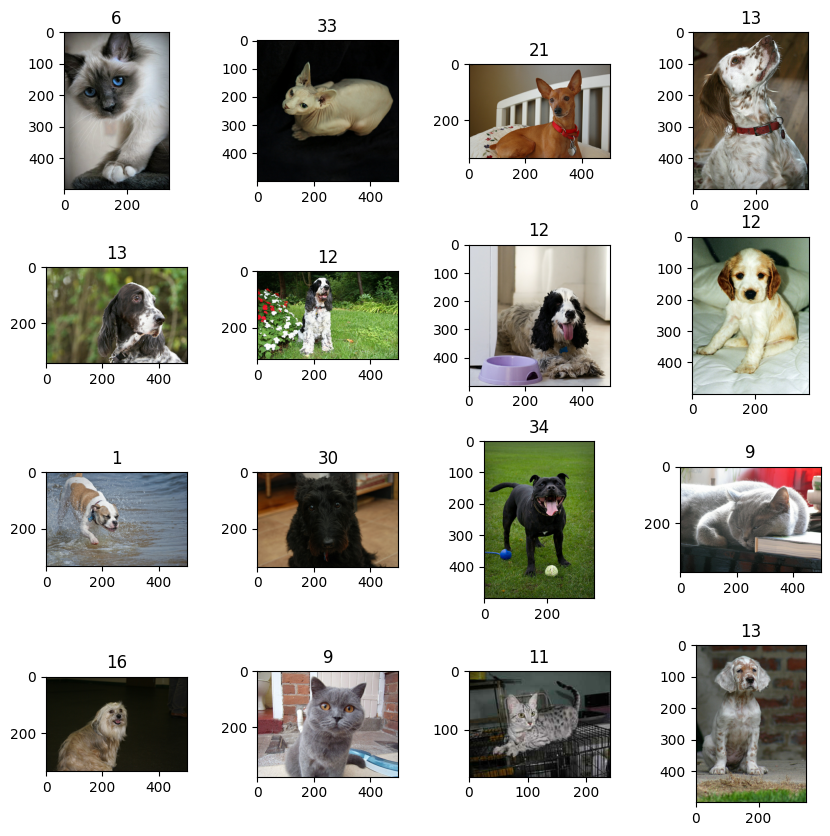

In [4]:
# checking the first 16 images in the train dataset
# integer above the image shows the pet breed it belong to
# The images are not in a same size
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("on")
plt.subplots_adjust(wspace=0.5, hspace=0.3)
# Because we have shuffled the dataset, .take method randomly choses the 16 images.

def process_images(image, label):
    image = tf.image.resize(image, (224, 224)) # Resizing to the relevant size
    image = tf.image.random_brightness(image, max_delta=0.2) # Randomly adjusting brightness
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5) # Randomly adjusting contrast
    image = tf.keras.applications.resnet.preprocess_input(image) # Normalizing
    return image, label

train_dataset = train_dataset.map(process_images)
validation_dataset = validation_dataset.map(process_images)
test_dataset = test_dataset.map(process_images)

In [ ]:
resize_fn = keras.layers.Resizing(224, 224)

train_dataset = train_dataset.map(lambda x, y: (resize_fn(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (resize_fn(x), y))
test_dataset = test_dataset.map(lambda x, y: (resize_fn(x), y))

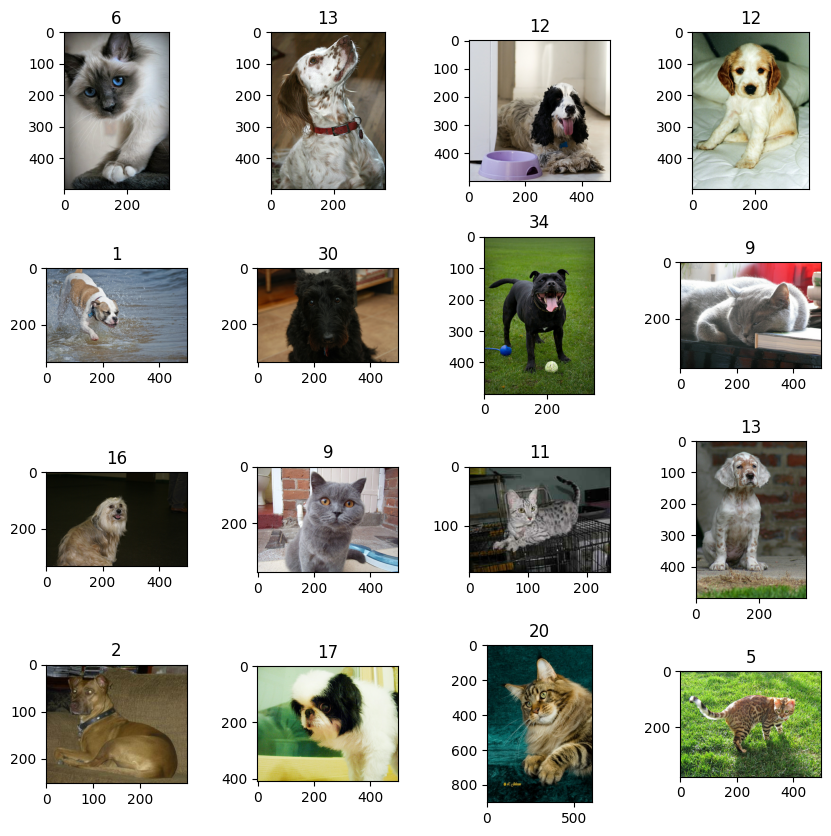

In [5]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("on")
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

In [6]:
# introducing flippings and small rotations to the dataset
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

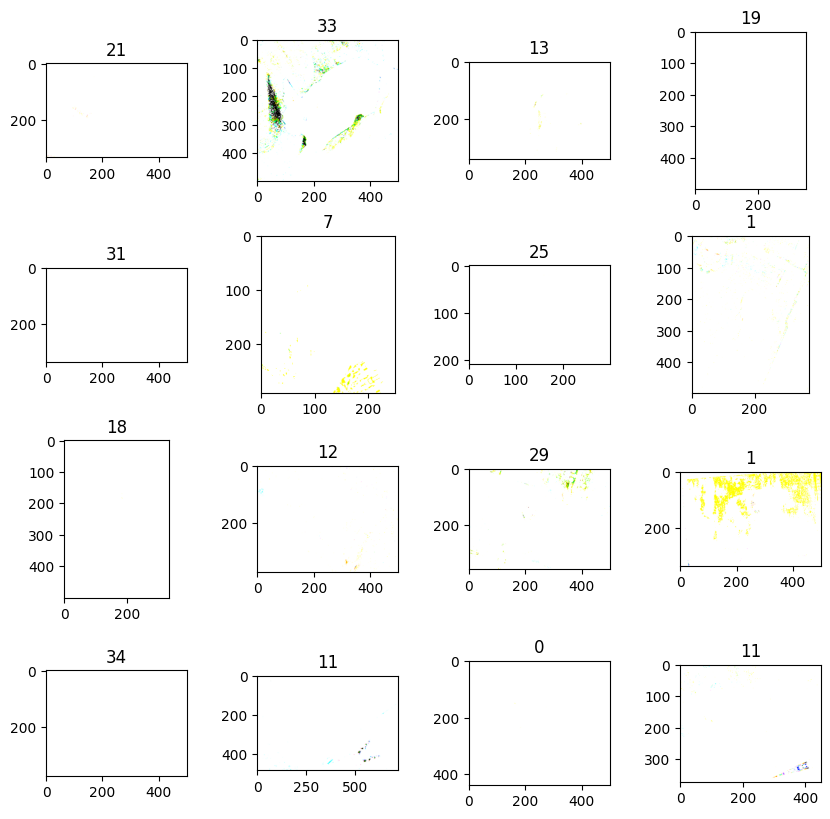

In [7]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("on")
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

In [8]:
batch_size = 32

train_dataset = train_dataset.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_dataset = validation_dataset.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_dataset = test_dataset.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

In [9]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [500,334,3], [batch]: [500,500,3] [Op:IteratorGetNext] name: 

In [ ]:
# Loading weights of pre-trained ResNet50 model on ImageNet
# Removing the ImageNet classifier at the top of the model
base_model = tf.keras.applications.resnet50.ResNet50(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False,
)

# Freeze the base_model and creating a new layer on top of the model
base_model.trainable = False
inputs = keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here
# Regularize is done dropout
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(37, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "model_11"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         Y          
                                                                            
 resnet50 (Functional)       (None, 7, 7, 2048)        2358771   N          
                                                       2                    
                                                                            
 global_average_pooling2d_6  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dropout_4 (Dropout)         (None, 2048)              0         Y          
                                                                            
 dense_11 (Dense)            (None, 37)                758

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

print("Test dataset evaluation")
model.evaluate(test_dataset)